# T5 Distillation

This notebook is an attempt to distill `t5-base` into `t5-small`. We fine-tune a total of 11 models, including a baseline `t5-small` (not distilled) for comparison. We also use a pre-trained `t5-base` as the teacher model. The dataset used in the experiments is the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

## Dependencies, datasets & dataloaders

First, we install the necessary dependencies:

In [144]:
!pip install transformers pytorch_lightning sentencepiece bs4 tqdm --quiet

Download of the dataset for fine-tuning later:

In [145]:
import os
import tqdm
import numpy as np
import pytorch_lightning as pl

pl.seed_everything(1234)

if not os.path.exists('aclImdb_v1.tar.gz'):
    !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

Global seed set to 1234


In [146]:
if not os.path.exists('./aclImdb'):
    !tar xf ./aclImdb_v1.tar.gz

Creation of a custom `Tokenizer` class for abstracting some operations/parameters:

In [147]:
from transformers import AutoTokenizer

class Tokenizer:
    def __init__(self, model_name, truncation=512):
        self.__tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.__truncation = truncation
    
    def encode(self, sentence):
        return self.__tokenizer(
            sentence,
            truncation=True,
            max_length=self.__truncation,
            padding='max_length',
            return_tensors='pt'
        )
    
    def decode(self, word_ids, *args, **kwargs):
        return self.__tokenizer.decode(word_ids, *args, **kwargs)
    
    def __call__(self, sentence):
        return self.encode(sentence)
    
    @property
    def pad_token_id(self):
        return self.__tokenizer.pad_token_id
    
tokenizer = Tokenizer('t5-small')
tokenized_output = tokenizer('this is a test')

decoded_output = tokenizer.decode(
    tokenized_output['input_ids'].squeeze(), 
    skip_special_tokens=True
)

assert tokenized_output['input_ids'].size(-1) == 512
assert tokenized_output['attention_mask'].size(-1) == 512
assert decoded_output == 'this is a test'

print(tokenizer.pad_token_id)

0


Dataset class for loading the training/test examples from files: 

In [148]:
from torch.utils.data import Dataset
from bs4 import BeautifulSoup

def get_filenames_with_labels(path):
    filenames_pos = [(f'{path}/pos/{filename}', 'positive') for filename in os.listdir(f'{path}/pos')]
    filenames_neg = [(f'{path}/neg/{filename}', 'negative') for filename in os.listdir(f'{path}/neg')]
    
    return filenames_pos + filenames_neg

class ImdbSentimentDataset(Dataset):
    def __init__(self, path, tokenizer):
        self.filenames = get_filenames_with_labels(path)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename, label = self.filenames[idx]
        
        file = open(filename, 'r')
        sentence = BeautifulSoup(file.read()).get_text()
        file.close()
        
        tokenized_input = self.tokenizer(sentence)
        tokenized_label = self.tokenizer(label)
        
        return (
            tokenized_input['input_ids'].squeeze(),
            tokenized_input['attention_mask'].squeeze(),
            tokenized_label['input_ids'].squeeze(),
            tokenized_label['attention_mask'].squeeze()
        )
    
train_ds = ImdbSentimentDataset('./aclImdb/train', tokenizer)
test_ds = ImdbSentimentDataset('./aclImdb/test', tokenizer)

print('Number of training examples:', len(train_ds))
print('Number of test examples:', len(test_ds))

sample_from_train = train_ds[0] 

assert sample_from_train[0].size(-1) == 512
assert sample_from_train[1].size(-1) == 512
assert sample_from_train[2].size(-1) == 512
assert sample_from_train[3].size(-1) == 512

Number of training examples: 25000
Number of test examples: 25000


In [149]:
from torch.utils.data import DataLoader

batch_size = 1

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

## Model definition & baseline fine-tuning 

This is the `pytorch_lightning` compatible model that we'll be using for training the baseline

In [150]:
import torch

from torch.optim import AdamW
from transformers import T5ForConditionalGeneration

class LightningT5(pl.LightningModule):
    def __init__(self, model_name, tokenizer):
        super().__init__()
        
        self.load_model(model_name)
        self.tokenizer = tokenizer
        
    def load_model(self, model_name):
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        
    def forward(self, x):
        return self.t5.generate(x)
    
    def configure_optimizers(self):
        return AdamW(self.t5.parameters(), lr=1e-5)
    
    def _step(self, batch):
        input_ids, attention_mask, labels, decoder_attention_mask = batch
        labels[labels[:] == self.tokenizer.pad_token_id] = -100
        
        return self.t5(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        ).loss
    
    def training_step(self, batch, idx):
        loss = self._step(batch)
        return loss
    
    def save_pretrained(self, path):
        self.t5.save_pretrained(path)
    
    validation_step = training_step
    test_step = training_step

Here we define our own `Trainer` class, which will call `pytorch_lightning`'s `Trainer` and save the trained model in a file. We also go ahead anf fine tune the baseline `t5-small` model.

In [151]:
import gc

class Trainer:
    def __init__(self, model, max_epochs, filename):
        self.model = model
        self.max_epochs = max_epochs
        self.filename = filename
        
    def train(self, train_dl, max_steps=None):
        gc.collect()
        
        model = self.model
        
        trainer = pl.Trainer(
            gpus=1,
            max_epochs=self.max_epochs,
            max_steps=max_steps
        )
        
        trainer.fit(model, train_dl)
        model.save_pretrained(self.filename)
        
        return model
    
    def train_or_load_pretrained(self, train_dl, force=False, **kwargs):
        if os.path.exists(self.filename) and not force:
            self.model.load_model(self.filename)
            return self.model
        
        return self.train(train_dl, **kwargs)

finetuned_t5_small = Trainer(LightningT5('t5-small', Tokenizer('t5-small')), 2, 'finetuned_t5small').train_or_load_pretrained(train_dl)

`Benchmark` class. It'll run the passed in model in the specified dataloader, sum the inference times from each example and calculate the accuracy for the whole dataset, all in the same loop. 

In [152]:
import time
import pickle
from contextlib import contextmanager

gpu = torch.device('cuda:0')
cpu = torch.device('cpu')

class Stopwatch:
    def __init__(self):
        self.reset()
        
    @contextmanager    
    def measure(self):
        start = time.perf_counter()
        yield
        stop = time.perf_counter()
        self.__times.append(stop - start)
        
    def total(self):
        return sum(self.__times)
    
    def reset(self):
        self.__times = []
        
class Benchmark:
    def __init__(self, test_dl, model, filename):
        self.test_dl = test_dl
        self.model = model
        self.results = None
        self.filename = filename
    
    @property    
    def tokenizer(self):
        return self.model.tokenizer
        
    def save_results(self):
        with open(self.filename, 'wb') as f:
            pickle.dump(self.results, f)
            
    def load_results(self):
        with open(self.filename, 'rb') as f:
            self.results = pickle.load(f)
            
    def run_or_load_results(self, force=False, *args, **kwargs):
        if not os.path.exists(self.filename) or force:
            self.run(*args, **kwargs)
            self.save_results()
        else:
            self.load_results()
        return self.results
           
    def run(self, max_iters=None, device=gpu):
        s = Stopwatch()
        n_iter = 0
        accuracy = 0
        
        self.model.to(device)
        
        for input_ids, _, label, _ in tqdm.tqdm(self.test_dl):
            if max_iters is not None and n_iter == max_iters:
                break
            
            output = None
            
            with s.measure():
                output = self.model(input_ids.to(device))
                
            pred = output.to(cpu).squeeze()
            label = label.squeeze()
            
            pred = tokenizer.decode(pred, skip_special_tokens=True)
            label = tokenizer.decode(label, skip_special_tokens=True)
            
            if pred == label:
                accuracy += 1
                
            n_iter += 1
            
        self.results = {
            'accuracy': accuracy / (max_iters if max_iters is not None else len(self.test_dl)),
            'time': s.total()
        }
        
        self.model.to(cpu)

Results for the baseline model:

In [153]:
finetuned_t5_small_benchmark = Benchmark(test_dl, finetuned_t5_small, 'finetuned_t5small_results.pickle')
finetuned_t5_small_benchmark.run_or_load_results()
finetuned_t5_small_benchmark.results

{'accuracy': 0.91684, 'time': 652.6982833680067}

Results for the `t5-base` model (that'll be used as teacher):

In [154]:
finetuned_t5_base = LightningT5('mrm8488/t5-base-finetuned-imdb-sentiment', Tokenizer('mrm8488/t5-base-finetuned-imdb-sentiment'))

In [155]:
finetuned_t5_base_benchmark = Benchmark(test_dl, finetuned_t5_base, 'finetuned_t5base_results.pickle')
finetuned_t5_base_benchmark.run_or_load_results()
finetuned_t5_base_benchmark.results

{'accuracy': 0.94892, 'time': 1511.636808633115}

## Experiments

First we define our distillation loss: 

In [156]:
from torch.nn import CrossEntropyLoss

class DistillationLoss:
    def __init__(self, temp=1, alpha=0.5):
        self.temp = temp
        self.alpha = alpha
        self.cel = CrossEntropyLoss()
    
    def __call__(self, teacher_logits, student_logits, labels):
        alpha = self.alpha
        t = self.temp
        
        l1 = -(
            (teacher_logits / t).softmax(dim=-1) * (student_logits / t).log_softmax(dim=-1)
        ).sum(dim=-1).mean()
        
        l2 = self.cel(student_logits.view(-1, student_logits.size(-1)), labels.view(-1))
        
        return alpha * l1 + (1 - alpha) * l2
    
def test_distillation_loss():
    input_ids, attention_mask, labels, decoder_attention_mask = train_ds[0]

    output_base = finetuned_t5_base.t5(
        input_ids=input_ids.unsqueeze(dim=0), 
        attention_mask=attention_mask.unsqueeze(dim=0), 
        labels=labels.unsqueeze(dim=0), 
        decoder_attention_mask=decoder_attention_mask.unsqueeze(dim=0)
    )

    output_small_untrained = T5ForConditionalGeneration.from_pretrained('t5-small')(
        input_ids=input_ids.unsqueeze(dim=0), 
        attention_mask=attention_mask.unsqueeze(dim=0), 
        labels=labels.unsqueeze(dim=0), 
        decoder_attention_mask=decoder_attention_mask.unsqueeze(dim=0)
    )
    
    criterion = DistillationLoss(temp=1, alpha=0.5)
    loss = criterion(output_base.logits, output_small_untrained.logits, labels)
    
    print(loss)
    
test_distillation_loss()

tensor(11.3334, grad_fn=<AddBackward0>)


Then we extend our `pytorch_lightning` model class to use that loss:

In [157]:
class LightningDistilledT5(LightningT5):
    def __init__(self, student_model_name, tokenizer, teacher_model, freeze_teacher=True, alpha=0, temp=1):
        super().__init__(student_model_name, tokenizer)
        self.teacher_model = teacher_model
        
        if freeze_teacher:
            for p in self.teacher_model.parameters():
                p.requires_grad = False
                
        self.criterion = DistillationLoss(temp=temp, alpha=alpha)  
    
    def _step(self, batch):
        input_ids, attention_mask, labels, decoder_attention_mask = batch
        labels[labels[:] == self.tokenizer.pad_token_id] = -100
        
        student_output = self.t5(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=self.t5._shift_right(labels),
            decoder_attention_mask=decoder_attention_mask
        )
        
        teacher_output = self.teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=self.t5._shift_right(labels),
            decoder_attention_mask=decoder_attention_mask
        )
        
        student_logits = student_output.logits
        teacher_logits = teacher_output.logits
        
        return self.criterion(teacher_logits, student_logits, labels)

### Temperature=1

`alpha=0.5`

In [162]:
distilled_t5_small_1_0 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=1,
        alpha=0.5
    ), 
    2, 
    'distillation_1_0'
).train_or_load_pretrained(train_dl)

In [163]:
distilled_t5_small_1_0_bench = Benchmark(test_dl, distilled_t5_small_1_0, 'distillation_1_0_results.pickle') # 1_0
distilled_t5_small_1_0_bench.run_or_load_results()
distilled_t5_small_1_0_bench.results

{'accuracy': 0.91988, 'time': 686.3376589473046}

`alpha=1`

In [164]:
distilled_t5_small_1_1 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=1,
        alpha=1
    ), 
    2, 
    'distillation_1_1'
).train_or_load_pretrained(train_dl)

In [165]:
distilled_t5_small_1_1_bench = Benchmark(test_dl, distilled_t5_small_1_1, 'distillation_1_1_results.pickle')
distilled_t5_small_1_1_bench.run_or_load_results()
distilled_t5_small_1_1_bench.results

{'accuracy': 0.89728, 'time': 679.6916478114435}

### Temperature=2

`alpha=0.5`

In [166]:
distilled_t5_small_2_0 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        alpha=0.5,
        temp=2
    ), 
    2, 
    'distillation_2_0'
).train_or_load_pretrained(train_dl)

In [167]:
distilled_t5_small_2_0_bench = Benchmark(test_dl, distilled_t5_small_2_0, 'distillation_2_0_results.pickle')
distilled_t5_small_2_0_bench.run_or_load_results()
distilled_t5_small_2_0_bench.results

{'accuracy': 0.91928, 'time': 664.636073136935}

`alpha=1`

In [168]:
distilled_t5_small_2_1 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        alpha=1,
        temp=2
    ), 
    2, 
    'distillation_2_1'
).train_or_load_pretrained(train_dl)

In [169]:
distilled_t5_small_2_1_bench = Benchmark(test_dl, distilled_t5_small_2_1, 'distillation_2_1_results.pickle')
distilled_t5_small_2_1_bench.run_or_load_results()
distilled_t5_small_2_1_bench.results

{'accuracy': 0.88392, 'time': 661.773972802046}

### Temperature=3

`alpha=0.5`

In [170]:
distilled_t5_small_3_0 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=3,
        alpha=0.5
    ), 
    2, 
    'distillation_3_0'
).train_or_load_pretrained(train_dl)

In [171]:
distilled_t5_small_3_0_bench = Benchmark(test_dl, distilled_t5_small_3_0, 'distillation_3_0_results.pickle')
distilled_t5_small_3_0_bench.run_or_load_results()
distilled_t5_small_3_0_bench.results

{'accuracy': 0.9244, 'time': 634.1156228439359}

`alpha=1`

In [172]:
distilled_t5_small_3_1 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=3,
        alpha=1
    ), 
    2, 
    'distillation_3_1'
).train_or_load_pretrained(train_dl)

In [173]:
distilled_t5_small_3_1_bench = Benchmark(test_dl, distilled_t5_small_3_1, 'distillation_3_1_results.pickle')
distilled_t5_small_3_1_bench.run_or_load_results()
distilled_t5_small_3_1_bench.results

{'accuracy': 0.84372, 'time': 696.22386425492}

### Temperature=4

`alpha=0.5`

In [174]:
distilled_t5_small_4_0 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=4,
        alpha=0.5
    ), 
    2, 
    'distillation_4_0'
).train_or_load_pretrained(train_dl)

In [175]:
distilled_t5_small_4_0_bench = Benchmark(test_dl, distilled_t5_small_4_0, 'distillation_4_0_results.pickle')
distilled_t5_small_4_0_bench.run_or_load_results()
distilled_t5_small_4_0_bench.results

{'accuracy': 0.91772, 'time': 705.2374351043836}

`alpha=1`

In [176]:
distilled_t5_small_4_1 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        temp=4,
        alpha=1
    ), 
    2, 
    'distillation_4_1'
).train_or_load_pretrained(train_dl)

In [177]:
distilled_t5_small_4_1_bench = Benchmark(test_dl, distilled_t5_small_4_1, 'distillation_4_1_results.pickle')
distilled_t5_small_4_1_bench.run_or_load_results()
distilled_t5_small_4_1_bench.results

{'accuracy': 0.80136, 'time': 701.600426985533}

### Temperature=5

`alpha=0.5`

In [158]:
distilled_t5_small_5_0 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        alpha=0.5,
        temp=5
    ), 
    2, 
    'distillation_5_0'
).train_or_load_pretrained(train_dl)

In [178]:
distilled_t5_small_5_0_bench = Benchmark(test_dl, distilled_t5_small_5_0, 'distillation_5_0_results.pickle')
distilled_t5_small_5_0_bench.run_or_load_results()
distilled_t5_small_5_0_bench.results

{'accuracy': 0.91696, 'time': 654.6962048942587}

`alpha=1`

In [160]:
distilled_t5_small_5_1 = Trainer(
    LightningDistilledT5(
        't5-small', 
        Tokenizer('t5-small'), 
        finetuned_t5_base.t5,
        alpha=1,
        temp=5
    ), 
    2, 
    'distillation_5_1'
).train_or_load_pretrained(train_dl)

In [179]:
distilled_t5_small_5_1_bench = Benchmark(test_dl, distilled_t5_small_5_1, 'distillation_5_1_results.pickle')
distilled_t5_small_5_1_bench.run_or_load_results()
distilled_t5_small_5_1_bench.results

{'accuracy': 0.7858, 'time': 658.2624420226493}

## Results

Accuracies for alpha=0.5
------------------------
Temperature=1 | 0.91988
Temperature=2 | 0.91928
Temperature=3 | 0.9244
Temperature=4 | 0.91772
Temperature=5 | 0.91696

Accuracies for alpha=1
------------------------
Temperature=1 | 0.89728
Temperature=2 | 0.88392
Temperature=3 | 0.84372
Temperature=4 | 0.80136
Temperature=5 | 0.7858

Baseline Accuracy: 0.91684
Teacher Accuracy: 0.94892


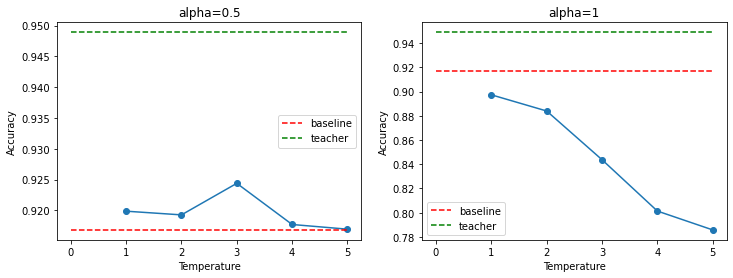

In [223]:
import matplotlib.pyplot as plt

results_0 = [
    distilled_t5_small_1_0_bench.results,
    distilled_t5_small_2_0_bench.results,
    distilled_t5_small_3_0_bench.results,
    distilled_t5_small_4_0_bench.results,
    distilled_t5_small_5_0_bench.results,
]

results_1 = [
    distilled_t5_small_1_1_bench.results,
    distilled_t5_small_2_1_bench.results,
    distilled_t5_small_3_1_bench.results,
    distilled_t5_small_4_1_bench.results,
    distilled_t5_small_5_1_bench.results,
]


accuracy_0 = [r['accuracy'] for r in results_0]
accuracy_1 = [r['accuracy'] for r in results_1]

print('Accuracies for alpha=0.5')
print('------------------------')

for t, a in enumerate(accuracy_0):
    print(f'Temperature={t + 1} | {a}')
    
print('\nAccuracies for alpha=1')
print('------------------------')

for t, a in enumerate(accuracy_1):
    print(f'Temperature={t + 1} | {a}')

baseline_accuracy = finetuned_t5_small_benchmark.results['accuracy']
teacher_accuracy = finetuned_t5_base_benchmark.results['accuracy']

print(f'\nBaseline Accuracy: {baseline_accuracy}')
print(f'Teacher Accuracy: {teacher_accuracy}')

fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].set_title('alpha=0.5')
ax[1].set_title('alpha=1')

ax[0].scatter(torch.arange(1, len(results_0) + 1), accuracy_0)
ax[0].plot(torch.arange(1, len(results_0) + 1), accuracy_0)
ax[0].plot((0, 5), (baseline_accuracy, baseline_accuracy), 'r--', label='baseline')
ax[0].plot((0, 5), (teacher_accuracy, teacher_accuracy), 'g--', label='teacher')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_aspect('auto')

ax[1].scatter(torch.arange(1, len(results_0) + 1), accuracy_1)
ax[1].plot(torch.arange(1, len(results_0) + 1), accuracy_1)
ax[1].plot((0, 5), (baseline_accuracy, baseline_accuracy), 'r--', label='baseline')
ax[1].plot((0, 5), (teacher_accuracy, teacher_accuracy), 'g--', label='teacher')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_aspect('auto')